**Imports for the project**

This section will import all the necessary packages

In [1]:
!conda install --yes --prefix {sys.prefix} -c conda-forge pyldavis
!conda install --yes --prefix {sys.prefix} -c conda-forge matplotlib
!pip install --prefix {sys.prefix} nlppreprocess
!conda install --yes --prefix {sys.prefix} -c anaconda seaborn
!conda install --yes --prefix {sys.prefix} -c anaconda nltk
!conda install --yes --prefix {sys.prefix} -c conda-forge wordcloud
!conda install --yes --prefix {sys.prefix} -c conda-forge spacy


EnvironmentLocationNotFound: Not a conda environment: /home/ec2-user/SageMaker/BRIT Success Classifier/{sys.prefix}


EnvironmentLocationNotFound: Not a conda environment: /home/ec2-user/SageMaker/BRIT Success Classifier/{sys.prefix}

  Using cached nlppreprocess-1.0.2-py3-none-any.whl (5.1 kB)
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/JupyterSystemEnv/bin/python -m pip install --upgrade pip' command.

DirectoryNotACondaEnvironmentError: The target directory exists, but it is not a conda environment.
Use 'conda create' to convert the directory to a conda environment.
  target directory: /home/ec2-user/SageMaker/BRIT Success Classifier/{sys.prefix}



DirectoryNotACondaEnvironmentError: The target directory exists, but it is not a conda environment.
Use 'conda create' to convert the directory to a conda environment.
  target directory: /home/ec2-user/SageMaker/BRIT Success Classifier/{sys.prefix}



DirectoryNotACondaEnvironmentError: The target directory exi

In [252]:
import numpy as np
import pandas as pd
import spacy
import os
import re
import sys
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle 
import pyLDAvis
import nltk
import nlppreprocess
import xgboost as xgb

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

from pyLDAvis import sklearn as sklearn_lda

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nlppreprocess import NLP

from scipy.sparse import hstack
from xgboost.sklearn import XGBClassifier

In [3]:
pd.__version__ #to confirm that pandas has been imported correctly

# Read data into papers
britFeedback = pd.read_csv('data/total_feedback_training.csv')
britFeedback.head()

,Candidate,Feedback,Vote,BRITSuccessful
0,Abhilash Shukla,Good smart candidate with raising the bar in L...,1,1
1,Abhilash Shukla,Candidate has some theoretical and broken know...,0,1
2,Abhilash Shukla,Not Inclined \n\nNot raising the bar functiona...,0,1
3,Abhilash Shukla,Inclined \n\nGood candidate with DC and hardwa...,1,1
4,Abhilash Shukla,"Matured candidate, raising bar in all area. Le...",0,1


In [4]:
britFeedback = britFeedback.drop(columns=['Candidate'], axis=1)

britFeedback.head()

,Feedback,Vote,BRITSuccessful
0,Good smart candidate with raising the bar in L...,1,1
1,Candidate has some theoretical and broken know...,0,1
2,Not Inclined \n\nNot raising the bar functiona...,0,1
3,Inclined \n\nGood candidate with DC and hardwa...,1,1
4,"Matured candidate, raising bar in all area. Le...",0,1


**Run XGBoost on initial dataset**

This will attempt to run XGBoost on the original dataset and see what the results are

In [12]:
train = britFeedback
column_names = ['BRITSuccessful']
train.head()
train = train.loc[:,column_names]
train.head()

,BRITSuccessful
0,1
1,1
2,1
3,1
4,1


In [26]:
train = britFeedback
test = pd.read_csv('data/total_feedback_testing.csv')
column_names = ['BRITSuccessful']

train_text = train['Feedback']
test_text = test['Feedback']
all_text = pd.concat([train_text, test_text])

train = train.loc[:,column_names]

print("TFIDF")
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1,1),
    norm='l2',
    min_df=0.1,
    max_df=0.5,
    smooth_idf=False,
    max_features=15000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    norm='l2',
    min_df=0.1,
    max_df=0.5,
    smooth_idf=False,
    max_features=50000)
char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

train_features = hstack([train_char_features, train_word_features])
del train_char_features,train_word_features
test_features = hstack([test_char_features, test_word_features])
del test_char_features,test_word_features

print(train_features.shape)
print(test_features.shape)
d_test = xgb.DMatrix(test_features)
del test_features
gc.collect()

print("Modeling")
cv_scores = []
xgb_preds = []
submission = pd.DataFrame.from_dict({'id': test['id']})

for column in column_names:    
    train_target = train[column]
    # Split out a validation set
    X_train, X_valid, y_train, y_valid = train_test_split(
    train_features, train_target, test_size=0.25, random_state=23)

    xgb_params = {'eta': 0.3, 
                  'max_depth': 5, 
                  'subsample': 0.8, 
                  'colsample_bytree': 0.8, 
                  'objective': 'binary:logistic', 
                  'eval_metric': 'auc', 
                  'seed': 23
                 }

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)

    watchlist = [(d_valid, 'valid')]
    model = xgb.train(xgb_params, d_train, 200, watchlist, verbose_eval=False, early_stopping_rounds=30)
    print("class Name: {}".format(column))
    print(model.attributes()['best_msg'])
    cv_scores.append(float(model.attributes()['best_score']))
    submission[column] = model.predict(d_test)
    del X_train, X_valid, y_train, y_valid
    gc.collect()

print('Total CV score is {}'.format(np.mean(cv_scores)))
submission.to_csv('data/xgboost_output_maxdf_05_mindf_01.csv', index=False)

TFIDF


/home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/BRIT_Classifier/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:520: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


(600, 22240)
(364, 22240)
Modeling
class Name: BRITSuccessful
[117]	valid-auc:0.79719
Total CV score is 0.797189


In [16]:
nltk.download('stopwords')
nltk.download('punkt')
english_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Remove punctuation and convert to lowercase**

This will conduct simple pre-processing and standardise the input of the Feedback column. We will need to use regex to remove punctuation and then lowercase the text.
Next step will also be to search for all occurrences of a follow-up question and replace it with "FUQ".

In [28]:
britFeedback['more_processed_feedback'] = britFeedback['Feedback'].apply(lambda x: [item for item in x if item not in english_words])
#Remove punctuation
britFeedback['processed_feedback'] = britFeedback['Feedback'].map(lambda x: re.sub('[\n(*,.!-)]', '', str(x)))

#Convert the feedback to lower case
britFeedback['processed_feedback'] = britFeedback['processed_feedback'].map(lambda x: x.lower())

#Print out the first few rows
britFeedback['processed_feedback'].head()

0    good smart candidate with raising the bar in l...
1    candidate has some theoretical and broken know...
2    not inclined not raising the bar functionally ...
3    inclined good candidate with dc and hardware e...
4    matured candidate raising bar in all area less...
Name: processed_feedback, dtype: object

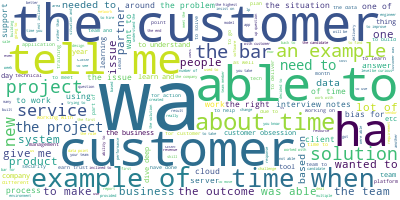

In [29]:
#Make one long string
long_string = ','.join(list(britFeedback['processed_feedback'].values))

#create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1500, contour_width=6, contour_color='steelblue')

#Generate a word cloud
wordcloud.generate(long_string)

#Visualise the word cloud
wordcloud.to_image()

**Get the data ready for LDA Analysis**

Time to transform the data into a format that we can use for input into the LDA model. First convert the documents into a Bag of Words, then convert the list of feedback into lists of vectors with length equal to the vocabulary.

Plot the most frequent words.

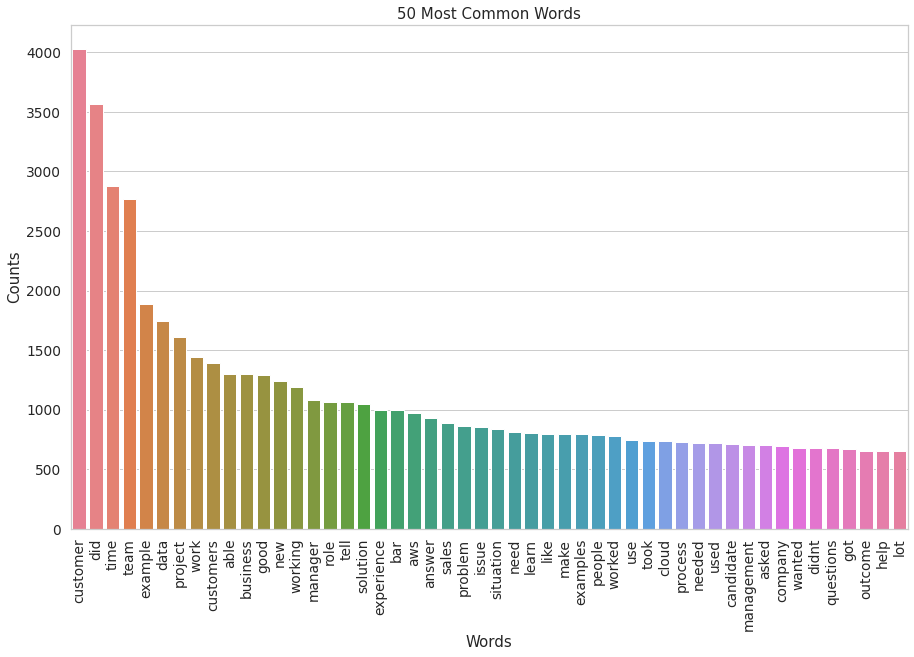

In [174]:
sns.set_style('whitegrid')
%matplotlib inline

#Helper function
def plotMostCommonWords(dataCount, vectoriserCount):
    words = vectoriserCount.get_feature_names()
    totalCount = np.zeros(len(words))
    for i in dataCount:
        totalCount += i.toarray()[0]
        
    dictionaryCount = (zip(words,totalCount))
    dictionaryCount = sorted(dictionaryCount, key=lambda x: x[1], reverse=True)[0:50]
    words = [w[0] for w in dictionaryCount]
    counts = [w[1] for w in dictionaryCount]
    xPosition = np.arange(len(words))
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='50 Most Common Words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(xPosition, counts, palette='husl')
    plt.xticks(xPosition, words, rotation=90)
    plt.xlabel('Words')
    plt.ylabel('Counts')
    plt.show()
    
#Initialise the count vectoriser with the English stop words
vectoriserCount = CountVectorizer(stop_words='english')

#Fit and transform the processed feedback
dataCount = vectoriserCount.fit_transform(britFeedback['processed_feedback'])

#Visualise the 20 most common words
plotMostCommonWords(dataCount, vectoriserCount)
    

In [175]:
warnings.simplefilter("ignore", DeprecationWarning)

# Helper function
def print_topics(model, vectoriserCount, n_top_words):
    words = vectoriserCount.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(dataCount)
print(lda.transform(dataCount))
pd.DataFrame(lda.transform(dataCount)).to_csv("data/lda_fitted_output_with_5_topics_unprocessed.csv",index=None, header=None)

# # Print the topics found by the LDA model
# print("Topics found via LDA:")
# print_topics(lda, vectoriserCount, number_words)

[[9.99477126e-01 1.28809908e-04 1.29823502e-04 1.31220813e-04
  1.33019487e-04]
 [9.99121424e-01 2.17627878e-04 2.18978253e-04 2.20674490e-04
  2.21295818e-04]
 [9.99386019e-01 1.52109186e-04 1.52828209e-04 1.54315457e-04
  1.54727912e-04]
 ...
 [1.03255321e-01 6.06623041e-04 6.12937752e-04 6.20717581e-04
  8.94904401e-01]
 [1.44900178e-01 1.86373781e-03 1.90314326e-03 1.86384727e-01
  6.64948215e-01]
 [7.90128718e-03 9.20257067e-02 7.79400004e-03 8.84331063e-01
  7.94794263e-03]]


In [176]:
sys.path.insert(0,"/home/ec2-user/anaconda3/lib/python3.6/site-packages/")

In [177]:
%%time

pyLDAvis.enable_notebook()

beginningPath = "./ldavisPrepared"
htmlEndPath = ".html"
LDAvis_data_filepath = os.path.join(beginningPath+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = sklearn_lda.prepare(lda, dataCount, vectoriserCount)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, beginningPath + str(number_topics) + htmlEndPath)

LDAvis_prepared
    

CPU times: user 24.2 s, sys: 148 ms, total: 24.4 s
Wall time: 17min 29s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.137702 -0.026717       1        1  48.059638
4     -0.116371  0.028699       2        1  34.346411
0     -0.065628  0.055232       3        1  13.663417
2      0.075783 -0.102544       4        1   2.828531
1      0.243917  0.045329       5        1   1.102004, topic_info=            Term         Freq        Total Category  logprob  loglift
7640         did  3389.000000  3389.000000  Default  30.0000  30.0000
10855       good  1204.000000  1204.000000  Default  29.0000  29.0000
21514   security   337.000000   337.000000  Default  28.0000  28.0000
6797        data  1640.000000  1640.000000  Default  27.0000  27.0000
4148   candidate   657.000000   657.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
10767      given     4.109290   292.288467   Topic5  -6.7351   0.2435
24062       task     3.896462   169.230153   Topic5  -6.7882   0.7368
13508        key     3.960851   279.969626   Topic5  -6.7718   0.2498
4148   candidate     3.899621   657.065106   Topic5  -6.7874  -0.6189
20785      right     3.706209   619.301145   Topic5  -6.8383  -0.6105

[434 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
510        5  0.748781      2fa
1055       1  0.564164     able
1055       2  0.336406     able
1055       3  0.086113     able
1055       4  0.012877     able
...      ...       ...      ...
27096      3  0.087708  working
27096      4  0.004385  working
27244      2  0.941412       xi
27331      3  0.985715     yesh
27394      3  0.925365      yum

[828 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 1, 3, 2])

In [180]:
%%time
#Initialise the count vectoriser with the English stop words
vectoriserCount = CountVectorizer(stop_words='english')

#Fit and transform the processed feedback
dataCount = vectoriserCount.fit_transform(britFeedback['processed_feedback'])



# Tweak the two parameters below (use int values below 15)
number_topics = 10
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(dataCount)
print(lda.transform(dataCount))
pd.DataFrame(lda.transform(dataCount)).to_csv("data/lda_fitted_output_with_10_topics_unprocessed.csv",index=None)


pyLDAvis.enable_notebook()

beginningPath = "./ldavisPrepared"
htmlEndPath = ".html"
LDAvis_data_filepath = os.path.join(beginningPath+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = sklearn_lda.prepare(lda, dataCount, vectoriserCount)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, beginningPath + str(number_topics) + htmlEndPath)

LDAvis_prepared
    

[[6.41943935e-05 9.16974796e-01 6.41987558e-05 ... 6.41891020e-05
  6.41858671e-05 8.25116560e-02]
 [1.08476031e-04 1.08490215e-04 1.08479108e-04 ... 1.08463329e-04
  1.08460480e-04 9.99023730e-01]
 [7.58273775e-05 7.58289951e-05 7.58282031e-05 ... 7.58182730e-05
  7.58155097e-05 9.99317581e-01]
 ...
 [3.01269177e-04 1.35288780e-01 3.01287513e-04 ... 3.01221716e-04
  3.01208055e-04 3.01284734e-04]
 [9.26142813e-04 7.94740133e-01 5.91418501e-02 ... 9.25953053e-04
  9.26059473e-04 9.26091556e-04]
 [3.84716405e-03 3.84718783e-03 3.84769952e-03 ... 2.01834751e-01
  3.84615393e-03 3.84667751e-03]]
CPU times: user 43 s, sys: 5.86 s, total: 48.9 s
Wall time: 17min 36s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.155671  0.054686       1        1  34.236793
3      0.126755 -0.001357       2        1  24.409163
1      0.105781 -0.039553       3        1  13.905027
9      0.069259 -0.079554       4        1   8.092852
6      0.078658  0.004166       5        1   6.804727
0      0.062106 -0.019831       6        1   6.410260
5      0.036082  0.018511       7        1   4.125036
4     -0.127990  0.144448       8        1   1.231144
7     -0.239308 -0.060977       9        1   0.561000
8     -0.267014 -0.020539      10        1   0.223999, topic_info=             Term         Freq        Total Category  logprob  loglift
24121        team  2602.000000  2602.000000  Default  30.0000  30.0000
21693     service   522.000000   522.000000  Default  29.0000  29.0000
21154       sales   878.000000   878.000000  Default  28.0000  28.0000
6568     customer  3875.000000  3875.000000  Default  27.0000  27.0000
16102         new  1163.000000  1163.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
5207    commented     0.636509    12.206553  Topic10  -7.0068   3.1476
281            19     0.596646    12.135399  Topic10  -7.0715   3.0887
3250       behalf     0.628164    21.909160  Topic10  -7.0200   2.5494
17527       parts     0.672460    53.950207  Topic10  -6.9519   1.7164
5822   consistent     0.614655    33.519211  Topic10  -7.0418   2.1025

[822 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
68         2  0.963178     10c
72         3  0.243459     10g
72         4  0.730376     10g
99         9  0.658478   11204
155        3  0.956557  12mbps
...      ...       ...     ...
27394      4  0.906753     yum
27396      5  0.852258    zack
27425      2  0.195919    zoom
27425      8  0.587756    zoom
27486      7  0.773386    ˇits

[1917 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 10, 7, 1, 6, 5, 8, 9])

In [182]:
%%time
#Initialise the count vectoriser with the English stop words
vectoriserCount = CountVectorizer(stop_words='english')

#Fit and transform the processed feedback
dataCount = vectoriserCount.fit_transform(britFeedback['processed_feedback'])



# Tweak the two parameters below (use int values below 15)
number_topics = 30
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(dataCount)
print(lda.transform(dataCount))
pd.DataFrame(lda.transform(dataCount)).to_csv("data/lda_fitted_output_with_30_topics_unprocessed.csv",index=None)


pyLDAvis.enable_notebook()

beginningPath = "./ldavisPrepared"
htmlEndPath = ".html"
LDAvis_data_filepath = os.path.join(beginningPath+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = sklearn_lda.prepare(lda, dataCount, vectoriserCount)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, beginningPath + str(number_topics) + htmlEndPath)

LDAvis_prepared
    

[[2.13949508e-05 2.13949508e-05 2.13949508e-05 ... 2.13949508e-05
  2.13949508e-05 2.13949508e-05]
 [3.61532899e-05 3.61532899e-05 3.61532899e-05 ... 3.61532899e-05
  3.61532899e-05 3.61532899e-05]
 [2.52716705e-05 2.52716705e-05 2.52716705e-05 ... 5.59436346e-01
  2.52716705e-05 2.52716705e-05]
 ...
 [1.00401606e-04 1.00401606e-04 1.00401606e-04 ... 1.00401606e-04
  1.00401606e-04 1.00401606e-04]
 [3.08641975e-04 3.08641975e-04 3.08641975e-04 ... 3.08641975e-04
  3.08641975e-04 3.08641975e-04]
 [1.28205128e-03 9.62820513e-01 1.28205128e-03 ... 1.28205128e-03
  1.28205128e-03 1.28205128e-03]]
CPU times: user 47.9 s, sys: 6.54 s, total: 54.5 s
Wall time: 17min 36s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.181434 -0.052473       1        1  33.467940
6      0.143144 -0.045027       2        1   9.066407
10     0.125729 -0.028224       3        1   5.961459
18     0.119537 -0.011790       4        1   5.957379
23     0.109065  0.160562       5        1   5.244954
8      0.117236  0.040385       6        1   4.919586
21     0.115240 -0.007210       7        1   4.088851
12     0.113960  0.052988       8        1   3.325376
29     0.103215 -0.013536       9        1   2.803972
22     0.100482 -0.037125      10        1   2.766289
7      0.089552 -0.013802      11        1   2.626652
20     0.081197 -0.018934      12        1   2.550022
17     0.093435  0.053979      13        1   2.476263
14     0.057587 -0.061390      14        1   2.338543
27     0.054676  0.142153      15        1   2.232562
1      0.045827 -0.025868      16        1   1.776501
24     0.038194 -0.046213      17        1   1.586259
0      0.002102 -0.079676      18        1   1.101371
5     -0.000807 -0.054664      19        1   1.080182
15    -0.016858  0.044172      20        1   0.938899
9     -0.032550 -0.046181      21        1   0.920987
2     -0.065187  0.050909      22        1   0.654634
3     -0.073707 -0.006620      23        1   0.549371
11    -0.177880 -0.021192      24        1   0.422795
19    -0.157132 -0.050043      25        1   0.327352
26    -0.175442  0.044728      26        1   0.292866
4     -0.246513 -0.003869      27        1   0.171206
16    -0.216729  0.029745      28        1   0.164248
28    -0.271289 -0.002111      29        1   0.112924
25    -0.257516  0.006328      30        1   0.074151, topic_info=              Term         Freq        Total Category  logprob  loglift
6568      customer  3902.000000  3902.000000  Default  30.0000  30.0000
7640           did  3376.000000  3376.000000  Default  29.0000  29.0000
18888      project  1489.000000  1489.000000  Default  28.0000  28.0000
24121         team  2636.000000  2636.000000  Default  27.0000  27.0000
14714      manager   990.000000   990.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
15737           mp     0.299894    14.492129  Topic30  -6.6538   3.3289
27200        write     0.366820    84.157717  Topic30  -6.4524   1.7712
14636  maintenance     0.362324    76.256597  Topic30  -6.4647   1.8575
2185           api     0.368289   115.832285  Topic30  -6.4484   1.4558
23489        style     0.354689    69.867412  Topic30  -6.4860   1.9237

[2417 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
1         19  0.871164            00am
4          3  0.142419              02
4          8  0.712094              02
4         18  0.142419              02
6          8  0.907948  04_davidxavier
...      ...       ...             ...
27425      8  0.158781            zoom
27425     19  0.793905            zoom
27426      4  0.899742         zoomcar
27457     15  0.890025            ëthe
27486     14  0.711102            ˇits

[8937 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 7, 11, 19, 24, 9, 22, 13, 30, 23, 8, 21, 18, 15, 28, 2, 25, 1, 6, 16, 10, 3, 4, 12, 20, 27, 5, 17, 29, 26])

In [36]:
documents = ''
for line in britFeedback['processed_feedback']:
    documents += line

In [37]:
bagOfWords = documents.split(' ')

In [38]:
uniqueWords = set(documents.split(' '))

In [39]:
numOfWords = dict.fromkeys(uniqueWords, 0)

for word in bagOfWords:
    numOfWords[word] += 1

In [165]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=0.1)

vector = vectorizer.fit_transform(britFeedback['processed_feedback'])
feature_names = vectorizer.get_feature_names()
dense = vector.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

In [41]:
df.to_csv('tfidf_output_wo_stopword_removal_training_data.csv')

**TF-IDF data frame before stop word removal without a minimum DF**

The below is a dataframe that shows the tf-idf values for each word in the corresponding document with stop words, and using no min-df

In [166]:
df.head()

,10,100,12,15,20,30,50,ability,above,access,...,without,won,works,write,wrong,year,years,yes,yet,yourself
0,0.029764,0.0,0.000000,0.067036,0.033628,0.0,0.019781,0.0,0.035655,0.000000,...,0.026302,0.000000,0.000000,0.041254,0.0,0.0,0.00000,0.0,0.0,0.041054
1,0.090753,0.0,0.060859,0.051100,0.051268,0.0,0.000000,0.0,0.000000,0.114672,...,0.000000,0.000000,0.051952,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000
2,0.036949,0.0,0.000000,0.041610,0.041746,0.0,0.000000,0.0,0.044262,0.046687,...,0.032652,0.097790,0.042303,0.051213,0.0,0.0,0.00000,0.0,0.0,0.000000
3,0.048342,0.0,0.000000,0.054439,0.054617,0.0,0.000000,0.0,0.000000,0.000000,...,0.085439,0.000000,0.055346,0.067004,0.0,0.0,0.01779,0.0,0.0,0.000000
4,0.100006,0.0,0.000000,0.032177,0.000000,0.0,0.000000,0.0,0.000000,0.180520,...,0.000000,0.037812,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000


In [43]:
df_check = df.apply(lambda x: ' '.join([str(word) for word in x if word > 0]))

**TF-IDF with no 0 values**

The below is a dataframe that shows the tf-idf values for each word in the corresponding document with stop words, and using no min-df, and with tf-idf values greater than 0

In [44]:
df_check.head()

00                                          0.03909748034686682
00am                                        0.10051665747111946
00assigned                                 0.036180578741426564
01                     0.029253377871687133 0.02684905141878541
02            0.1227802939713003 0.04710393980778963 0.02790...
dtype: object

In [45]:
df_check.to_csv('tfidf_output_removing_0_values_pre_stopwords_training_data.csv')

In [46]:
tokens = word_tokenize(long_string)

In [47]:
tokens_without_sw = [word for word in tokens if not word in english_words]

In [48]:
long_string_without_sw = ','.join(tokens_without_sw)

In [49]:
wordcloud.generate(long_string_without_sw)

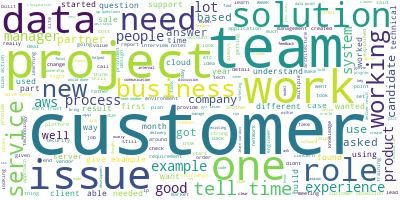

In [50]:
wordcloud.to_image()

In [51]:
britFeedback['processed_feedback'].head()

0    good smart candidate with raising the bar in l...
1    candidate has some theoretical and broken know...
2    not inclined not raising the bar functionally ...
3    inclined good candidate with dc and hardware e...
4    matured candidate raising bar in all area less...
Name: processed_feedback, dtype: object

In [52]:
britFeedback['more_processed_feedback'] = britFeedback['processed_feedback'].apply(lambda x: ' '.join([word for word in x.split() if word not in (english_words)]))

In [53]:
britFeedback['more_processed_feedback'].head()

0    good smart candidate raising bar lp functional...
1    candidate theoretical broken knowledge raising...
2    inclined raising bar functionally lp wise bit ...
3    inclined good candidate dc hardware experience...
4    matured candidate raising bar area less hand-o...
Name: more_processed_feedback, dtype: object

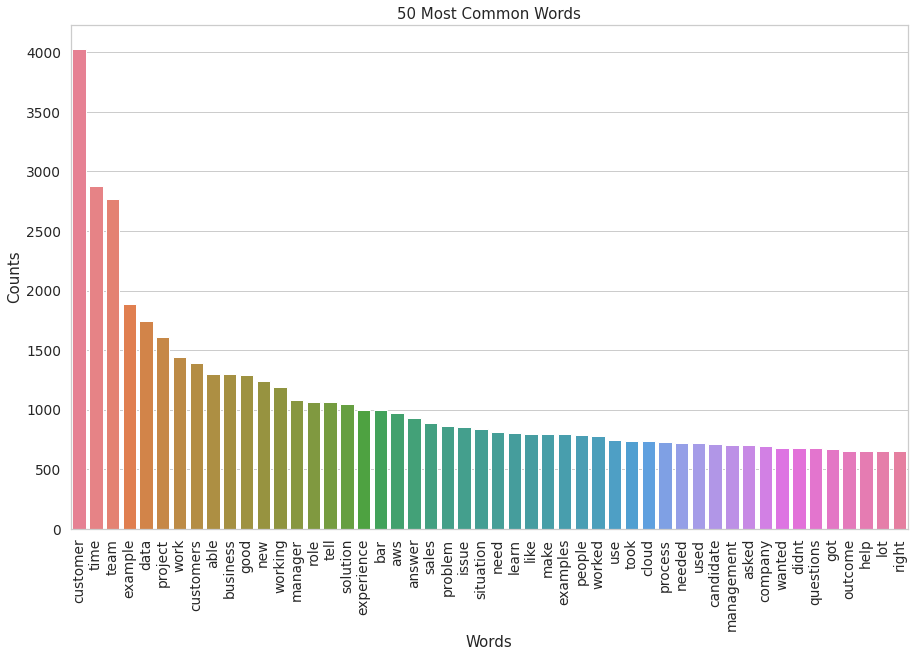

In [254]:

updatedData = vectoriserCount.fit_transform(britFeedback['more_processed_feedback'])


#Visualise the 50 most common words
plotMostCommonWords(updatedData, vectoriserCount)

In [55]:
vector = vectorizer.fit_transform(britFeedback['more_processed_feedback'])
feature_names = vectorizer.get_feature_names()
dense = vector.todense()
denselist = dense.tolist()
df_after_stop_word_removal = pd.DataFrame(denselist, columns=feature_names)

In [56]:
df_after_stop_word_removal.to_csv('tfidf_output_after_stop_words_training_data.csv')

In [57]:
nlp = NLP()
#nlp.add_replacement([followupquestionscan="fuq", followupquestion="fuq", followup="fuq", fuqs="fuq", fuqdid="fuq", fup="fuq"])

In [58]:
britFeedback['again_more_processed_feedback'] = britFeedback['more_processed_feedback'].apply(nlp.process)

In [59]:
df_after_stop_word_removal = df_after_stop_word_removal.apply(nlp.process)

In [60]:
df_after_stop_word_removal.to_csv('tfidf_output_after_stop_words_training_data.csv')

In [61]:
britFeedback['again_more_processed_feedback'].head()

0    good smart candidate raising bar lp functional...
1    candidate theoretical broken knowledge raising...
2    inclined raising bar functionally lp wise bit ...
3    inclined good candidate dc hardware experience...
4    matured candidate raising bar area less hand o...
Name: again_more_processed_feedback, dtype: object

In [258]:
from spacy.cli import download
print(download('en'))

⚠ Skipping model package dependencies and setting `--no-deps`. You
don't seem to have the spaCy package itself installed (maybe because you've
built from source?), so installing the model dependencies would cause spaCy to
be downloaded, which probably isn't what you want. If the model package has
other dependencies, you'll have to install them manually.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/BRIT_Classifier/lib/python3.6/site-packages/en_core_web_sm
-->
/home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/BRIT_Classifier/lib/python3.6/site-packages/spacy/data/en
You can now load the model via spacy.load('en')
None


In [267]:
updatedData2 = vectoriserCount.fit_transform(britFeedback['again_more_processed_feedback'])
from pandas import DataFrame
sp = spacy.load('en')
#print(sp(britFeedback['more_processed_feedback']))

tokens = []
lemma = []
pos = []

for doc in sp.pipe(britFeedback['again_more_processed_feedback'].astype('unicode').values, batch_size=50,n_threads=3):
    if doc.is_parsed:
        tokens.append([n.text for n in doc])
        lemma.append([n.lemma_ for n in doc])
        pos.append([n.pos_ for n in doc])
    else:
        tokens.append(None)
        lemma.append(None)
        pos.append(None)

df = DataFrame(lemma, columns=['Lemma']);

df.head()

#Visualise the 50 most common words
# plotMostCommonWords(updatedData2, vectoriserCount)

ValueError: 1 columns passed, passed data had 1890 columns

In [62]:
vector = vectorizer.fit_transform(britFeedback['again_more_processed_feedback'])
feature_names = vectorizer.get_feature_names()
dense = vector.todense()
denselist = dense.tolist()
df_after_stop_word_removal_2 = pd.DataFrame(denselist, columns=feature_names)

**TF-IDF data frame after stop word removal**

The below is a dataframe that shows the tf-idf values for each word in the corresponding document without stop words, and using a min-df value of 0.05

In [63]:
df_after_stop_word_removal_2.head()

,aa,aaa,aadhar,aai,aailable,aainst,aand,aarnet,aaron,aashish,...,zombie,zombiefollow,zone,zonea,zonejuniper,zones,zoom,zoomcar,zte,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.083767,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.095979,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
df_after_stop_word_removal_2.to_csv('tfidf_output_after_nlp_process_training_data.csv')

In [178]:
updated_vectorizer = TfidfVectorizer(max_df=0.5, min_df=0.1)
vector = updated_vectorizer.fit_transform(britFeedback['again_more_processed_feedback'])
feature_names = updated_vectorizer.get_feature_names()
dense = vector.todense()
denselist = dense.tolist()
df_after_stop_word_removal_3 = pd.DataFrame(denselist, columns=feature_names)
df_after_stop_word_removal_3.head()

,ability,access,account,accounts,achieve,across,action,actions,activities,actual,...,within,without,works,write,wrong,year,years,yes,yet,you
0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.055839,0.026207,0.000000,0.041307,0.0,0.0,0.000000,0.000000,0.0,0.102897
1,0.0,0.117943,0.000000,0.0,0.000000,0.0,0.038194,0.0,0.0,0.000000,...,0.043938,0.000000,0.053433,0.000000,0.0,0.0,0.000000,0.055113,0.0,0.161933
2,0.0,0.047244,0.040790,0.0,0.041566,0.0,0.000000,0.0,0.0,0.026169,...,0.000000,0.033041,0.042807,0.052079,0.0,0.0,0.000000,0.000000,0.0,0.129730
3,0.0,0.000000,0.052257,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.084660,0.054842,0.066719,0.0,0.0,0.017593,0.000000,0.0,0.166201
4,0.0,0.189930,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.028302,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.104308


In [110]:
test_vectorizer = TfidfVectorizer(min_df=0.1, max_df=0.5)
testpd = pd.read_csv('data/total_feedback_testing.csv')
vector = test_vectorizer.fit_transform(testpd['Feedback'])
feature_names = test_vectorizer.get_feature_names()
dense = vector.todense()
denselist = dense.tolist()
df_test = pd.DataFrame(denselist, columns=feature_names)
df_test.head()

,10,100,12,15,20,30,50,ability,above,access,...,without,won,works,wouldn,wrong,year,years,yes,yet,yourself
0,0.000000,0.000000,0.0,0.000000,0.000000,0.065565,0.0,0.0,0.0,0.0,...,0.048512,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.064275,0.000000,0.0,0.000000,0.079533,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.059169,0.0,0.0,0.0,0.0
2,0.000000,0.093479,0.0,0.093479,0.087638,0.258245,0.0,0.0,0.0,0.0,...,0.063692,0.0,0.0,0.099888,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.054058,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.048613,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [114]:
# #Initialise the count vectoriser with the English stop words
# vectoriserCount = CountVectorizer(stop_words='english')

# #Fit and transform the processed feedback
# dataCount = vectoriserCount.fit_transform(britFeedback['processed_feedback'])

warnings.simplefilter("ignore", DeprecationWarning)

# Helper function
def print_topics(model, vectoriserCount, n_top_words):
    words = vectoriserCount.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 30
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(vector)
print(lda.transform(vector))
pd.DataFrame(lda.transform(vector)).to_csv("data/lda_fitted_output_with_30_topics_test_data.csv",index=None, header=None)

[[0.00324004 0.00324004 0.00324004 ... 0.00324004 0.00324004 0.00324004]
 [0.00350288 0.00350288 0.00350288 ... 0.00350288 0.00350288 0.00350288]
 [0.00317901 0.00317901 0.00317901 ... 0.00317901 0.00317901 0.00317901]
 ...
 [0.00261844 0.00261844 0.00261844 ... 0.00261844 0.00261844 0.00261844]
 [0.00237328 0.00237328 0.00237328 ... 0.00237328 0.00237328 0.00237328]
 [0.00252354 0.00252354 0.00252354 ... 0.00252354 0.00252354 0.00252354]]


In [111]:
df_after_stop_word_removal_3.to_csv('tf-idf/tfidf_output_maxdf_05_mindf_01.csv')
df_test.to_csv('tf-idf/tfidf_output_maxdf_05_mindf_01_testing.csv')

In [103]:
df_after_stop_word_removal_3.head()

,ability,access,account,accounts,achieve,across,action,actions,activities,actual,...,within,without,works,write,wrong,year,years,yes,yet,you
0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.055839,0.026207,0.000000,0.041307,0.0,0.0,0.000000,0.000000,0.0,0.102897
1,0.0,0.117943,0.000000,0.0,0.000000,0.0,0.038194,0.0,0.0,0.000000,...,0.043938,0.000000,0.053433,0.000000,0.0,0.0,0.000000,0.055113,0.0,0.161933
2,0.0,0.047244,0.040790,0.0,0.041566,0.0,0.000000,0.0,0.0,0.026169,...,0.000000,0.033041,0.042807,0.052079,0.0,0.0,0.000000,0.000000,0.0,0.129730
3,0.0,0.000000,0.052257,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.084660,0.054842,0.066719,0.0,0.0,0.017593,0.000000,0.0,0.166201
4,0.0,0.189930,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.028302,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.104308


In [170]:
train = britFeedback
test = pd.read_csv('data/total_feedback_testing.csv')
column_names = ['BRITSuccessful']

train_text = train['again_more_processed_feedback']
test_text = test['Feedback']
all_text = pd.concat([train_text, test_text])

train = train.loc[:,column_names]

print("TFIDF")
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1,1),
    norm='l2',
#     min_df=0.1,
    max_df=0.5,
    smooth_idf=False,
    max_features=15000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    norm='l2',
#     min_df=0.1,
    max_df=0.5,
    smooth_idf=False,
    max_features=50000)
char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

train_features = hstack([train_char_features, train_word_features])
del train_char_features,train_word_features
test_features = hstack([test_char_features, test_word_features])
del test_char_features,test_word_features

print(train_features.shape)
print(test_features.shape)
d_test = xgb.DMatrix(test_features)
del test_features
gc.collect()

print("Modeling")
cv_scores = []
xgb_preds = []
submission = pd.DataFrame.from_dict({'id': test['id']})

for column in column_names:    
    train_target = train[column]
    # Split out a validation set
    X_train, X_valid, y_train, y_valid = train_test_split(
    train_features, train_target, test_size=0.25, random_state=23)

    xgb_params = {'eta': 0.3, 
                  'max_depth': 5, 
                  'subsample': 0.8, 
                  'colsample_bytree': 0.8, 
                  'objective': 'binary:logistic', 
                  'eval_metric': 'auc', 
                  'seed': 23
                 }

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)

    watchlist = [(d_valid, 'valid')]
    model = xgb.train(xgb_params, d_train, 200, watchlist, verbose_eval=False, early_stopping_rounds=30)
    print("class Name: {}".format(column))
    print(model.attributes()['best_msg'])
    cv_scores.append(float(model.attributes()['best_score']))
    submission[column] = model.predict(d_test)
    del X_train, X_valid, y_train, y_valid
    gc.collect()

print('Total CV score is {}'.format(np.mean(cv_scores)))
submission.to_csv('data/xgboost_output_processed_maxdf_05.csv', index=False)

TFIDF
  (0, 14966)	0.06913832298999789
  (0, 14878)	0.029843339180756528
  (0, 14868)	0.03208905161907542
  (0, 14839)	0.06944649742411772
  (0, 14800)	0.03262944663163017
  (0, 14749)	0.03458474491053523
  (0, 14677)	0.033032864712695446
  (0, 14663)	0.015643297324214645
  (0, 14561)	0.04498399681902343
  (0, 14552)	0.03211443301716493
  (0, 14548)	0.029370482763383395
  (0, 14525)	0.033176330996920876
  (0, 14514)	0.013756937446819351
  (0, 14490)	0.06333087227284415
  (0, 14451)	0.042584730520994825
  (0, 14375)	0.02926772322557325
  (0, 14366)	0.04104641371103396
  (0, 14340)	0.0431552018102317
  (0, 14320)	0.025179127345203455
  (0, 14267)	0.06552052103685872
  (0, 14259)	0.018803415102740098
  (0, 14184)	0.03475607033403526
  (0, 14084)	0.02239713544200027
  (0, 14082)	0.0088664072901978
  (0, 14079)	0.03377472854887937
  :	:
  (598, 2619)	0.15099746562364819
  (598, 2504)	0.05127325873406986
  (598, 2272)	0.08421104652722534
  (598, 1990)	0.06613192440488487
  (598, 1116)	0.2020

/home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/BRIT_Classifier/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:520: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


(600, 65000)
(364, 65000)
Modeling
class Name: BRITSuccessful
[155]	valid-auc:0.73065
Total CV score is 0.730653


In [158]:
train_data_with_lda = pd.read_csv('data/train_data_tfidf_with_lda_30_topics.csv')
test_data_with_lda = pd.read_csv('data/test_data_tfidf_with_lda_30_topics.csv')
#print(train_data_with_lda)
X_train, X_valid, y_train, y_valid = train_test_split(
    train_data_with_lda, train_data_with_lda['BRITSuccessful'], test_size=0.25, random_state=23)

d_test = xgb.DMatrix(test_data_with_lda)
gc.collect()

print("Modeling")
cv_scores = []
xgb_preds = []
submission = pd.DataFrame.from_dict({'id': test_data_with_lda['id']})

xgb_params = {'eta': 0.3, 
                  'max_depth': 5, 
                  'subsample': 0.8, 
                  'colsample_bytree': 0.8, 
                  'objective': 'binary:logistic', 
                  'eval_metric': 'auc', 
                  'seed': 23
            }

d_train = xgb.DMatrix(X_train, y_train)
d_valid = xgb.DMatrix(X_valid, y_valid)

watchlist = [(d_valid, 'valid')]
model = xgb.train(xgb_params, d_train, 200, watchlist, verbose_eval=False, early_stopping_rounds=30)
print("class Name: {}".format('BRITSuccessful'))
print(model.attributes()['best_msg'])
cv_scores.append(float(model.attributes()['best_score']))
#submission['BRITSuccessful'] = model.predict(d_test)
# del X_train, X_valid, y_train, y_valid
# gc.collect()

# print('Total CV score is {}'.format(np.mean(cv_scores)))
#print(train_data_with_lda.tocsc())
# accuracy = train_model(xgb.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())

Modeling
class Name: BRITSuccessful
[0]	valid-auc:1.00000


In [186]:
%%time
#Initialise the count vectoriser with the English stop words
vectoriserCount = CountVectorizer(stop_words='english')

#Fit and transform the processed feedback
dataCount = vectoriserCount.fit_transform(britFeedback['again_more_processed_feedback'])



# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(dataCount)
print(lda.transform(dataCount))
pd.DataFrame(lda.transform(dataCount)).to_csv("data/lda_fitted_output_with_5_topics_processed.csv",index=None)


pyLDAvis.enable_notebook()

beginningPath = "./ldavisPrepared"
htmlEndPath = ".html"
LDAvis_data_filepath = os.path.join(beginningPath+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = sklearn_lda.prepare(lda, dataCount, vectoriserCount)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, beginningPath + str(number_topics) + htmlEndPath)

LDAvis_prepared
    

[[1.34377295e-04 1.32252935e-04 9.99465571e-01 1.34328071e-04
  1.33470928e-04]
 [9.99083618e-01 2.26402034e-04 2.31244786e-04 2.30627117e-04
  2.28107893e-04]
 [1.61817293e-04 1.59518968e-04 9.63065575e-01 3.64522121e-02
  1.60876508e-04]
 ...
 [6.31395983e-04 6.23136005e-04 5.39089310e-01 4.59031825e-01
  6.24333177e-04]
 [9.41133346e-01 2.03404176e-03 5.27194318e-02 2.07002404e-03
  2.04315662e-03]
 [8.20866170e-03 8.05004920e-03 9.67563123e-01 8.16084729e-03
  8.01731879e-03]]
CPU times: user 39.3 s, sys: 5.12 s, total: 44.5 s
Wall time: 14min 57s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.158505 -0.002823       1        1  64.162666
3      0.128324 -0.000216       2        1  24.945674
0      0.062936  0.019913       3        1   7.865110
4     -0.155033 -0.102374       4        1   1.700358
1     -0.194732  0.085500       5        1   1.326192, topic_info=             Term         Freq        Total Category  logprob  loglift
32           able  1232.000000  1232.000000  Default  30.0000  30.0000
5371     customer  3865.000000  3865.000000  Default  29.0000  29.0000
7879      example  1794.000000  1794.000000  Default  28.0000  28.0000
3027    candidate   665.000000   665.000000  Default  27.0000  27.0000
22311        team  2672.000000  2672.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
14846      number     6.158302   240.961671   Topic5  -6.4778   0.6560
22595        test     5.997564   195.030719   Topic5  -6.5042   0.8411
8177      explain     5.642661   186.209153   Topic5  -6.5652   0.8263
22605     testing     5.486084   184.872866   Topic5  -6.5934   0.8054
9524   government     5.393754   128.449200   Topic5  -6.6103   1.1526

[398 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
32         1  0.751846     able
32         2  0.163833     able
32         3  0.071373     able
32         4  0.002433     able
32         5  0.010544     able
...      ...       ...      ...
25168      3  0.055322  working
25168      4  0.002634  working
25304      5  0.909902       xi
25411      3  0.960463      yin
25455      5  0.898777     zack

[749 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 5, 2])

In [231]:
from csv import DictReader
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, accuracy_score
IN_FOLDER = 'data/'
def read_data(name):
    text, targets = [], []
    
    with open(''.join([IN_FOLDER, '{}.csv']).format(name)) as f:
        for item in DictReader(f):
            text.append(item['Feedback'])
            targets.append(item['BRITSuccessful'])
            
    return text, targets

text_train, targets_train = read_data('total_feedback_training')
text_test, targets_test = read_data('total_feedback_testing_with_label')

baseline_model = make_pipeline(TfidfVectorizer(), LogisticRegression(), ).fit(text_train, targets_train)
baseline_prediction = baseline_model.predict(text_test)
baseline_score_training = f1_score(targets_train, baseline_model.predict(text_train), average='macro')
baseline_score = f1_score(targets_test, baseline_prediction, average='macro')
previous_score = baseline_score
print('baseline macro f1: ', baseline_score, 'baseline macro f1 (training): ', baseline_score_training)
print(classification_report(targets_test, baseline_prediction))

baseline macro f1:  0.5473214285714286 baseline macro f1 (training):  0.891095960340779
              precision    recall  f1-score   support

           0       0.47      0.42      0.44       149
           1       0.63      0.68      0.65       215

    accuracy                           0.57       364
   macro avg       0.55      0.55      0.55       364
weighted avg       0.56      0.57      0.57       364



In [232]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import LatentDirichletAllocation

class TextStats(BaseEstimator, TransformerMixin):
    """Returns the length of the post (as number of tokens) and the number of question marks"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        return [(len(tokenizer.tokenize(text)), text.count('?'))
                for text in posts]

# Latent Dirichlet Allocation
lda = Pipeline([('tf', CountVectorizer(strip_accents='unicode', stop_words='english')),
                ('lda',LatentDirichletAllocation(n_components=30, max_iter=50, learning_method='online', #'online', 
                                                 learning_offset=50.,doc_topic_prior=.1, topic_word_prior=.01,
                                                 random_state=0))])
# All together
feats =  FeatureUnion([('text_len', TextStats()), ('lda', lda),
                       ('tfidf', TfidfVectorizer(strip_accents='unicode', min_df=0.1, max_df=0.5, ngram_range=(1, 2)))])

In [233]:
from time import time
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

t0 = time()

lda = Pipeline([('tf', CountVectorizer(strip_accents='unicode', stop_words='english')),
                ('lda',LatentDirichletAllocation(n_components=30, max_iter=50, learning_method='online', #'online', 
                                                 learning_offset=50.,doc_topic_prior=.1, topic_word_prior=.01,
                                                 random_state=0)), ])

feats =  FeatureUnion([('text_len', TextStats()), ('lda', lda), 
                       ('tfidf', TfidfVectorizer(strip_accents='unicode', ngram_range=(1, 2)))])

lr_model = make_pipeline(feats, LogisticRegression(C=1., penalty='l2', random_state=0), ).fit(text_train, targets_train)
lr_prediction = lr_model.predict(text_test)

print('training score:', f1_score(targets_train, lr_model.predict(text_train), average='macro'))
lr_macro_f1 = f1_score(targets_test, lr_prediction, average='macro')
print('testing score:', lr_macro_f1)

print("done in %0.3fs." % (time() - t0))
print(classification_report(targets_test, lr_prediction))

training score: 0.8893496216651205
testing score: 0.5578388666661509
done in 42.048s.
              precision    recall  f1-score   support

           0       0.47      0.50      0.49       149
           1       0.64      0.61      0.63       215

    accuracy                           0.57       364
   macro avg       0.56      0.56      0.56       364
weighted avg       0.57      0.57      0.57       364



In [214]:
from nltk import stem
stemmer = stem.PorterStemmer()

def porter_stem(sentence):
    # Porter stemming 
    stemmed_sequence = [stemmer.stem(word) for word in tokenizer.tokenize(sentence)
                        if word not in stopwords.words('english')]
    return ' '.join(stemmed_sequence)

stemmed_train = [porter_stem(post) for post in text_train]
stemmed_test = [porter_stem(post) for post in text_test]

In [228]:
t0 = time()


lda = Pipeline([('tf', CountVectorizer(strip_accents='unicode', stop_words='english')),
                ('lda',LatentDirichletAllocation(n_components=30, max_iter=20, learning_method='online', 
                                                 learning_offset=50.,doc_topic_prior=.1, topic_word_prior=.01,
                                                 random_state=0)), ])

lda_tfidf_features =  FeatureUnion([('lda', lda),
                                    ('tfidf', TfidfVectorizer(strip_accents='unicode',min_df=0.2))])

stem_lr_model = make_pipeline(lda_tfidf_features, LogisticRegression(C=1.5, penalty='l2', random_state=0)
                             ).fit(stemmed_train, targets_train)
stem_lr_prediction = stem_lr_model.predict(stemmed_test)

print('training score:', f1_score(targets_train, stem_lr_model.predict(stemmed_train), average='macro'))
stem_lr_macro_f1 = f1_score(targets_test, stem_lr_prediction, average='macro')
print('testing score:', stem_lr_macro_f1)

print("done in %0.3fs." % (time() - t0))
print(classification_report(targets_test, stem_lr_prediction))

training score: 0.8382731162748908
testing score: 0.5177706715395157
done in 11.153s.
              precision    recall  f1-score   support

           0       0.43      0.52      0.47       149
           1       0.61      0.52      0.56       215

    accuracy                           0.52       364
   macro avg       0.52      0.52      0.52       364
weighted avg       0.54      0.52      0.53       364



In [240]:
t0 = time()

stem_xgb_model = make_pipeline(TfidfVectorizer(strip_accents='unicode', ngram_range=(1, 2), max_df=0.5, min_df=0.1), 
                               xgb.XGBClassifier(max_depth=10, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, 
                                                 gamma=.01, reg_alpha=5, objective='multi:softmax',num_class=3)
                              ).fit(text_train, targets_train) 

stem_xgb_prediction = stem_xgb_model.predict(text_test)

stem_xgb_macro_f1 = f1_score(targets_test, stem_xgb_prediction, average='macro')

print('training score:', f1_score(targets_train, stem_xgb_model.predict(text_train), average='macro'))
stem_xgb_macro_f1 = f1_score(targets_test, stem_xgb_prediction, average='macro')
print('testing score:', stem_xgb_macro_f1)

print("done in %0.3fs." % (time() - t0))
print(classification_report(targets_test, stem_xgb_prediction))

training score: 1.0
testing score: 0.5768505718235516
done in 8.491s.
              precision    recall  f1-score   support

           0       0.50      0.48      0.49       149
           1       0.65      0.67      0.66       215

    accuracy                           0.59       364
   macro avg       0.58      0.58      0.58       364
weighted avg       0.59      0.59      0.59       364



In [246]:
t0 = time()

stem_xgb_model = make_pipeline(TfidfVectorizer(strip_accents='unicode', min_df=0.15, ngram_range=(1, 2)), 
                               xgb.XGBClassifier(max_depth=10, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, 
                                                 gamma=.02, reg_alpha=5, objective='multi:softmax', num_class=3)
                              ).fit(stemmed_train, targets_train) 

stem_xgb_prediction = stem_xgb_model.predict(stemmed_test)

stem_xgb_macro_f1 = f1_score(targets_test, stem_xgb_prediction, average='macro')

print('training score:', f1_score(targets_train, stem_xgb_model.predict(stemmed_train), average='macro'))
stem_xgb_macro_f1 = f1_score(targets_test, stem_xgb_prediction, average='macro')
print('testing score:', stem_xgb_macro_f1)

print("done in %0.3fs." % (time() - t0))
print(classification_report(targets_test, stem_xgb_prediction))

training score: 1.0
testing score: 0.5383693698600295
done in 4.961s.
              precision    recall  f1-score   support

           0       0.45      0.46      0.46       149
           1       0.62      0.61      0.62       215

    accuracy                           0.55       364
   macro avg       0.54      0.54      0.54       364
weighted avg       0.55      0.55      0.55       364



In [247]:
lda_df = pd.read_csv('data/lda_fitted_output_with_30_topics_processed_tfidf.csv')
lda_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.003202,0.003202,0.003202,0.003202,0.003202,0.003202,0.003202,0.003202,0.003202,0.003202,...,0.003202,0.003202,0.898636,0.003202,0.011703,0.003202,0.003202,0.003202,0.003202,0.003202
1,0.003466,0.003466,0.003466,0.003466,0.003466,0.003466,0.003466,0.003466,0.003466,0.003466,...,0.003466,0.003466,0.899491,0.003466,0.003466,0.003466,0.003466,0.003466,0.003466,0.003466
2,0.003369,0.003369,0.003369,0.003369,0.003369,0.003369,0.003369,0.003369,0.003369,0.003369,...,0.003369,0.003369,0.902292,0.003369,0.003369,0.003369,0.003369,0.003369,0.003369,0.003369
3,0.003394,0.003394,0.003394,0.003394,0.003394,0.003394,0.003394,0.003394,0.003394,0.003394,...,0.003394,0.003394,0.894616,0.003394,0.010359,0.003394,0.003394,0.003394,0.003394,0.003394
4,0.003810,0.003810,0.003810,0.003810,0.003810,0.003810,0.003810,0.003810,0.003810,0.003810,...,0.003810,0.003810,0.880245,0.003810,0.013075,0.003810,0.003810,0.003810,0.003810,0.003810
